In [1]:
import argparse
import numpy as np
import pandas as pd
import sys
from scipy.sparse import load_npz, csr_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, brier_score_loss

In [59]:
from scipy.special import logit, expit
sigmoid = expit

def compute_metrics(y, y_pred):
    acc = accuracy_score(y, np.round(y_pred))
    auc = roc_auc_score(y, y_pred)
    nll = log_loss(y, y_pred, labels=[0,1])
    mse = brier_score_loss(y, y_pred)
    return acc, auc, nll, mse

default_bins = [(i*.05, (i+1)*.05) for i in range(20)]
def metrics_by_prob(df, y_pred, y, real_probs, bins=default_bins):
    mbp = []
    for low, high in bins:
        inds = np.nonzero((real_probs > low) & (real_probs <= high))[0]
        b_df, b_pred, b_y, b_probs = df.iloc[inds,:], y_pred[inds], y[inds], real_probs[inds]
        
        acc = accuracy_score(b_y, np.round(b_pred))
        # Skip AUC, it isn't well-defined these subsets of data
        nll = log_loss(b_y, b_pred,labels=[0,1])
        mse = brier_score_loss(b_y, b_pred)
        
        prob_stats = {"acc" : acc, "nll" : nll, "mse" : mse, "N" : len(b_y)}
        prob_stats.update(under_over_stats(b_df, b_pred, b_y, b_probs))
        mbp.append(((low,high), prob_stats))

    acc, auc, nll, mse = compute_metrics(y, y_pred)
    stats = {"acc" : acc, "auc" : auc, "nll" : nll, "mse" : mse, "metrics_by_prob" : mbp}
    print(f"TOTAL: ACC {acc:.4f} AUC {auc:.4f} MSE {mse:.4f} LOG LOSS: {nll:.4f}")
    return stats

def mean_nonzero_counts(counts):
    if(np.any(counts.index.isin([0]))):
        counts = counts.drop(0)    
    total = counts.sum()
    if(total == 0.0):
        return 0.0
    return (counts.index*counts).sum() / total
    

def prob_nonzero(counts):
    if(np.any(counts.index.isin([0]))):
        zero_count = counts.at[0]
    else:
        return 1.0
        
    total = counts.sum()
    if(total == 0.0):
        return 0.0
    return 1.0-(zero_count / total)

def under_over_stats(df, y_pred, y, real_probs, thresh=.85):
    df = df.copy()
    pPm = (y_pred >= thresh) # Predicted Positive mask
    Pm = (real_probs >= thresh) # Ground-Truth Positive mask
    pNm = (y_pred < thresh) # Predicted Negative mask
    Nm = (real_probs < thresh) # Ground-Truth Negative mask

    FPm = pPm & Nm # False Positive mask
    FNm = pNm & Pm # False Negative Mask

    df['over_prac'] = FNm
    df['under_prac'] = FPm
    over_by_stu_kc = df['over_prac'].groupby([df['user_id'], df['skill_id']]).sum() 
    under_by_stu_kc = df['under_prac'].groupby([df['user_id'], df['skill_id']]).sum() 
    avg_over_prac = over_by_stu_kc.mean()
    avg_under_prac = under_by_stu_kc.mean()

    over_counts = over_by_stu_kc.value_counts()
    under_counts = under_by_stu_kc.value_counts()


        
    #print(over_counts)
    #print("Rate(Over)", prob_nonzero(over_counts))
    #print("Rate(Under)", prob_nonzero(under_counts))
    #print("Avg(#Over Practice|Over)", mean_nonzero_counts(over_counts))
    #print("Avg(#Under Practice|Under)", mean_nonzero_counts(under_counts))
    #print(f"Avg Over Practice: {avg_over_prac:.3f} Avg Under Practice: {avg_under_prac:.3f}")

    stats = {
        "over_prob" : prob_nonzero(over_counts),
        "under_prob" : prob_nonzero(under_counts),
        "over_counts" : {k:v for k,v in zip(over_counts.index, over_counts)},
        "under_counts" : {k:v for k,v in zip(under_counts.index, under_counts)},
        "avg_over_mag" : mean_nonzero_counts(over_counts),
        "avg_under_mag" : mean_nonzero_counts(under_counts),
        "avg_over" : mean_nonzero_counts(over_counts),
        "avg_under" : mean_nonzero_counts(under_counts),
    }
    return stats
    

def mastery_residual(y_pred, y, real_probs, slopes, thresh=.85):
    # NOTE: This function is a legacy attempt to quantify over/under practice
    
    # NOTE: For now using absolute slopes... check that fitting is correct
    slopes = np.abs(slopes)
    
    pPm = (y_pred >= thresh) # Predict Positive mask
    Pm = (real_probs >= thresh) # Positive mask
    pNm = (y_pred < thresh) # Predict Negative mask
    Nm = (real_probs < thresh) # Negative mask

    FPm = pPm & Nm # True positive mask
    FNm = pNm & Pm # False positive Mask
    
    TP = np.sum(pPm & Pm) # True positives
    FP = np.sum(pPm & Nm) # False positives
    TN = np.sum(pNm & Nm) # True negatives
    FN = np.sum(pNm & Pm) # False negatives

    F1 = (2*TP) / (2*TP + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    acc = (TP + TN)/ (TP + TN + FP + FN)
    acc2 = accuracy_score(y_pred >= thresh, real_probs >= thresh)
    print(f"Mastery F1:{F1:.3f}, precision:{precision:3f} recall:{recall:.3f}, acc:{acc:.3f} acc2:{acc2:.3f}")

    # Need to clip the y_prediction so that it is never larger than thresh or less than 1-thresh 
    #  to ensure we don't get numerical stability issues from 
    clipped_y_pred = np.clip(y_pred, 1.0-thresh, thresh)
    #FP_resid = logit(clipped_y_pred[FPm]) - logit(real_probs[FPm])
    #FN_resid = logit(real_probs[FNm])-logit(clipped_y_pred[FNm])

    FP_resid = logit(thresh) - logit(real_probs[FPm])
    FN_resid = logit(real_probs[FNm]) - logit(thresh)
    
    #FP_resid = y_pred[FPm]-real_probs[FPm]
    #FN_resid = -(y_pred[FNm]-real_probs[FNm])
    #print(y_pred[FPm]-real_probs[FPm], FP_resid, np.argwhere(np.isnan(FP_resid)))
    

    #under_slope_aprox = sigmoid( (logit(.85) - logit(real_probs[FPm])) / slopes[FPm])-.5
    #over_slope_aprox = sigmoid( (logit(real_probs[FNm]) - logit(.85)) / slopes[FNm])-.5
    #print(under_slope_aprox)
    #print(over_slope_aprox)
    
    # Conditional i.e. given was FP or FN how many problems off is the estimate.
    cond_under_resid = np.mean(FP_resid/slopes[FPm])
    cond_over_resid = np.mean(FN_resid/slopes[FNm])

    # Expected under and over practice
    exp_under_resid = cond_under_resid * (FP / (TP+FP))
    exp_over_resid = cond_over_resid * (FN / (TN+FN))
    
    print(f"Residuals FP/TP: {np.mean(FP_resid):.3f}({FP}/{TP+FP}) {np.mean(FN_resid):.3f}({FN}/{TN+FN})")
    print(f"Conditional #Prob Under/Over: {cond_under_resid:.3f}({FP}/{TP+FP}) {cond_over_resid:.3f}({FN}/{TN+FN})")
    print(f"Expected #Prob Under/Over: {exp_under_resid:.3f} {exp_over_resid:.3f}")

    return FP_resid, FP_resid
    


dataset = "assistments09"
X_file = "X-sscwa.npz"

names_to_codes = {
    "BestLR" : "isicsctcwa",
    "PFA" : "sscwa"
}

from sklearn.model_selection import ShuffleSplit

splits = {}
n_folds = 5
def make_splits(dataset, n_splits=n_folds, test_size=0.1):
    if(dataset not in splits):
        df = pd.read_csv(f'data/real/{dataset}/preprocessed_data.csv', sep="\t")
        unq_ids = df["user_id"].unique()
        splitter =ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=0)
        splits[dataset] = list(splitter.split(unq_ids))
    return splits[dataset]
    
def get_data_dir(dataset, sim_src):
    is_sim = sim_src != "real"
    inner_dir = f"sim-{sim_src}" if is_sim else "real"
    
    return f'data/{inner_dir}/{dataset}'
    
def load_data(dataset, sim_src="real", fold_num=0):
    is_sim = sim_src != "real"
    
    users_train, users_test = make_splits(dataset)[fold_num]
    dir = get_data_dir(dataset, sim_src)
    print("is_sim", is_sim, sim_src)
    filename = "preprocessed_data.csv" if not is_sim else f"{dataset}.csv"
    full_df = pd.read_csv(f"{get_data_dir(dataset, sim_src)}/{filename}", sep="\t")
    train_df = full_df[full_df["user_id"].isin(users_train)]
    test_df = full_df[full_df["user_id"].isin(users_test)]

    if(is_sim):
        train_probs = train_df['prob'].to_numpy()
        test_probs = test_df['prob'].to_numpy()
        return train_df, test_df, (train_probs, test_probs)
    else:
        return train_df, test_df, (None, None)
    
def load_lr_data(dataset, model_code="sscwa", sim_src="real", fold_num=0):
    model_code = names_to_codes.get(model_code, model_code)
    train_df,  test_df, true_probs = load_data(dataset, sim_src, fold_num)

    dir = get_data_dir(dataset, sim_src)
    X = csr_matrix(load_npz(f'{dir}/X-{model_code}.npz'))
    #if(is_sim):
        
    #else:
    #    X = csr_matrix(load_npz(f'data/{dataset}/X-{model_code}.npz'))
    
    user_ids = X[:, 0].toarray().flatten()
    users_train = train_df["user_id"].unique()
    users_test = test_df["user_id"].unique()
    train = X[np.where(np.isin(user_ids, users_train))]
    test = X[np.where(np.isin(user_ids, users_test))]
    #print(users_test)

    X_train, y_train = train[:, 5:], train[:, 3].toarray().flatten()
    X_test, y_test = test[:, 5:], test[:, 3].toarray().flatten()
    train_kc_ids = train_df["skill_id"].to_numpy()
    test_kc_ids = test_df["skill_id"].to_numpy()

    return (X_train, y_train), (X_test, y_test), true_probs, (train_kc_ids, test_kc_ids)
  
    

def fit_lr(X_train, y_train):
    model = LogisticRegression(solver="lbfgs", max_iter=1000)
    model.fit(X_train, y_train)
    return model

def eval_lr(model, data):
    X, y = data
    #test_df[f"LR_{features_suffix}"] = y_pred_test
    #test_df.to_csv(f'data/{args.dataset}/preprocessed_data_test.csv', sep="\t", index=False)
    y_pred = model.predict_proba(X)[:, 1]

    acc, auc, nll, mse = compute_metrics(y, y_pred)
    return auc

def load_fit_eval_lr(dataset, model_code="sscwa", sim_src="real", fold_num=0):
    train, test, probs, kc_ids = load_lr_data(dataset, model_code, sim_src, fold_num)
    model = fit_lr(*train)
    
    auc_train = eval_lr(model, train)
    auc_test = eval_lr(model, test)
    stats = {"auc" : auc_test}

    if(is_sim):
        #
        X_test, y_test = test
        y_pred = model.predict_proba(X_test)[:, 1]
        
        _,test_probs = probs
        _,test_kc_ids = kc_ids
        
        #params_df = pd.read_csv(f'simulation/model-values/pfa_kc_params.csv', sep=",")
        #params_df = params_df[params_df['Dataset'] == dataset]

        # This is very weird... there shouldn't be an S or F Intercept, just a slope
        #slopes_by_kc = params_df["S_Slope/KC"].to_numpy() + params_df["PFA_S_Intercept"].to_numpy()
        #test_slopes = slopes_by_kc[test_kc_ids]
        #print(slopes_by_kc.shape, test_kc_ids.shape, test_slopes.shape)
        #mastery_residual(y_pred, y_test, test_probs,  test_slopes)

        _, test_df, _ = load_data(dataset, sim_src, fold_num)
        
        stats.update(under_over_stats(test_df, y_pred, y_test, test_probs))
        stats.update(metrics_by_prob(test_df, y_pred, y_test, test_probs))

    return stats

#print(load_fit_eval_lr("assistments09", "PFA", sim_src="BestLR"))
#print(load_fit_eval_lr("assistments09", "BestLR", is_sim=True))

In [54]:
import argparse
import pandas as pd
from random import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score

import torch.nn as nn
from torch.optim import Adam
from torch.nn.utils.rnn import pad_sequence

from model_dkt2 import DKT2
from train_dkt2 import get_data, prepare_batches, compute_auc, compute_loss, train
from utils import *
batch_size=64

def train_deep(train_df, test_df, hid_size=200, embed_size=200, num_hid_layers=1, drop_prob=.5, _batch_size=64,
              log_dir='runs/dkt', savedir='save/dkt',
              lr=1e-2, num_epochs=100, seed=0):
    global batch_size
    batch_size = _batch_size

    set_random_seeds(seed)


    #load_data(dataset,)
    #train_df = pd.read_csv(os.path.join('data', dataset, 'preprocessed_data_train.csv'), sep="\t")
    #test_df = pd.read_csv(os.path.join('data', dataset, 'preprocessed_data_test.csv'), sep="\t")

    train_data, val_data = get_data(train_df, train_split=0.8)


    max_item = max(int(train_df["item_id"].max()), int(test_df["item_id"].max()))
    max_skill = max(int(train_df["skill_id"].max()), int(test_df["skill_id"].max()))

    model = DKT2(max_item, max_skill, hid_size,
                 embed_size, num_hid_layers, drop_prob).cuda()
    
    optimizer = Adam(model.parameters(), lr=lr)

    # Reduce batch size until it fits on GPU
    while True:
        try:
            # Train
            param_str = f"{dataset}"
            logger = Logger(os.path.join(log_dir, param_str))
            saver = Saver(savedir, param_str)
            train(train_data, val_data, model, optimizer, logger, saver, num_epochs, batch_size)
            break
        except RuntimeError as e:
            print(e)
            batch_size = batch_size // 2
            print(f'Batch does not fit on gpu, reducing size to {batch_size}')
    
    logger.close()
    return model

    
def eval_deep(model, test_df, savedir='save/dkt'):
    if(isinstance(model, str)):
        saver = Saver(savedir, model)
        model = saver.load()
    test_data, _ = get_data(test_df, train_split=1.0, randomize=False)
    test_batches = prepare_batches(test_data, batch_size, randomize=False)
    test_preds = np.empty(0)
    test_skill_preds = np.empty(0)

    # Predict on test set
    model.eval()
    for item_inputs, skill_inputs, label_inputs, item_ids, skill_ids, labels in test_batches:
        print(item_ids.unique())
        with torch.no_grad():
            item_inputs = item_inputs.cuda()
            skill_inputs = skill_inputs.cuda()
            label_inputs = label_inputs.cuda()
            item_ids = item_ids.cuda()
            skill_ids = skill_ids.cuda()

            # Make the per-item prediction
            preds = model(item_inputs, skill_inputs, label_inputs, item_ids, skill_ids)
            preds = torch.sigmoid(preds[labels >= 0]).cpu().numpy()
            test_preds = np.concatenate([test_preds, preds])

            # Make a per-skill prediction (zero-out the item one-hot)
            _item_ids = (-torch.ones_like(item_ids)).cuda()
            skill_preds = model(item_inputs, skill_inputs, label_inputs, _item_ids, skill_ids)
            skill_preds = torch.sigmoid(skill_preds[labels >= 0]).cpu().numpy()
            test_skill_preds = np.concatenate([test_skill_preds, skill_preds])

    return test_preds, test_skill_preds
    

def _load_fit_eval_deep(dataset, sim_src="real", fold_num=0, q=None):
    #try:
        is_sim = sim_src != "real"
        train_df, test_df, true_probs = load_data(dataset, sim_src, fold_num=fold_num)
        model = train_deep(train_df, test_df)
        torch.cuda.empty_cache() 
        #auc_train = eval_deep(model, train_df)
        test_item_preds, test_skill_preds = eval_deep(model, test_df)
        item_stats, skill_stats = {}, {}
        if(is_sim):
            _, test_probs = true_probs
            y_test = test_df["correct"].to_numpy()
    
            train_kc_ids = train_df["skill_id"].to_numpy()
            test_kc_ids = test_df["skill_id"].to_numpy()
            
            # This is very weird... there shouldn't be an S or F Intercept, just a slope
            #params_df = pd.read_csv(f'simulation/model-values/pfa_kc_params.csv', sep=",")
            #params_df = params_df[params_df['Dataset'] == dataset]
            #slopes_by_kc = params_df["S_Slope/KC"].to_numpy() + params_df["PFA_S_Intercept"].to_numpy()
            #test_slopes = slopes_by_kc[test_kc_ids]
            
            #mastery_residual(test_preds, y_test, test_probs, test_slopes)
            item_stats.update(under_over_stats(test_df, test_item_preds, y_test, test_probs))
            item_stats.update(metrics_by_prob(test_df, test_item_preds, y_test, test_probs))

            skill_stats.update(under_over_stats(test_df, test_skill_preds, y_test, test_probs))
            skill_stats.update(metrics_by_prob(test_df, test_skill_preds, y_test, test_probs))
    
        else:
            #train_preds = eval_deep(model, train_df)
            
            acc, auc, nll, mse = compute_metrics(test_df["correct"], test_item_preds)
            item_stats = {"acc" : acc, "auc" : auc, "nll" : nll, "mse" : mse}

            acc, auc, nll, mse = compute_metrics(test_df["correct"], test_skill_preds)
            skill_stats = {"acc" : acc, "auc" : auc, "nll" : nll, "mse" : mse}
        #train_preds = roc_auc_score(train_df["correct"], train_preds)
        #test_preds = roc_auc_score(test_df["correct"], test_preds)
        if(q):
            q.put((item_stats, skill_stats))
            sys.exit(0)
    #except Exception as e:
    #    print(e)
        #sys.exit(1)
    
    #return stats

import multiprocessing as mp
import time
def load_fit_eval_deep(dataset, is_sim=False, fold_num=0):

    # Use a seperate process so that the GPU memory is definitely freed when finished
    q = mp.Queue()
    p = mp.Process(target=_load_fit_eval_deep, args=(dataset, is_sim, fold_num, q))
    p.start()

    
    while True:
        p.join(1) # Block for 1 second
        if(p.exitcode == 0):
            break
        # Terminate if there was an error
        if(p.exitcode is not None and p.exitcode != 0):
            p.terminate()
            break
    
    stats, skill_stats = q.get()
    return stats, skill_stats

    



In [95]:
import json
all_stats = {}
def get_cond_statspath(dataset, sim_src, model, kind, fold_num=0):
    k = "i" if kind == "item" else "s"
    file_path = f"model_stat_store/{dataset}({sim_src})-{model}-{k}-f{fold_num}.json"
    return file_path
    
def set_stats(dataset, sim_src, model, item_stats, skill_stats=None, fold_num=0):
    # Save item stats
    all_stats[(dataset, sim_src, model, 'item')] = item_stats
    with open(get_cond_statspath(dataset, sim_src, model, 'item', fold_num), 'w') as f:
        json.dump(item_stats, f)

    # Save skill stats if available
    if(skill_stats):
        all_stats[(dataset, sim_src, model, 'skill')] = skill_stats
        with open(get_cond_statspath(dataset, sim_src, model, 'skill', fold_num), 'w') as f:
            json.dump(skill_stats, f)

def get_stats(dataset, sim_src, model, kind='item', fold_num=0):
    tup = (dataset, sim_src, model, kind)
    if(tup in all_stats):
        return all_stats[tup]
        
    with open(get_cond_statspath(dataset, sim_src, model, kind, fold_num), 'r') as f:
        stats = json.load(f)
    return stats

def _select(o, selector):
    for sel in selector:
        o = o[sel]
    return o

def _write_stats(o, d, selector):
    for i, sel in enumerate(selector):
        if(i==len(selector)-1):
            o[sel] = d
        else:
            _o = o.get(sel, {})
            o[sel] = _o
            
def _avg_stats(out_stats, all_stats, selector):
    vals = [_select(o, selector) for o in all_stats]
    d = {"avg" : np.mean(vals), "std" : np.std(vals)}
    _write_stats(out_stats, d, selector)
    
    

def get_kfold_stats(dataset, sim_src, model, kind='item', n_folds=5):
    out_stats = {}
    all_stats = [get_stats(dataset, sim_src, model, kind, fold_num) for fold_num in range(n_folds)]
    _avg_stats(out_stats, all_stats, ['auc'])
    _avg_stats(out_stats, all_stats, ['over_prob'])
    _avg_stats(out_stats, all_stats, ['under_prob'])
    _avg_stats(out_stats, all_stats, ['avg_over_mag'])
    _avg_stats(out_stats, all_stats, ['avg_under_mag'])
    _avg_stats(out_stats, all_stats, ['avg_over'])
    _avg_stats(out_stats, all_stats, ['avg_under'])
    _avg_stats(out_stats, all_stats, ['acc'])
    _avg_stats(out_stats, all_stats, ['nll'])
    _avg_stats(out_stats, all_stats, ['mse'])

    metrics_by_prob = []
    for i, (span, d) in enumerate(all_stats[0]['metrics_by_prob']):
        all_bin_stats = [d] + [all_stats[j]['metrics_by_prob'][i][1] for j in range(1, n_folds)]
        bin_stats = {}
        _avg_stats(bin_stats, all_bin_stats, ['acc'])
        _avg_stats(bin_stats, all_bin_stats, ['nll'])
        _avg_stats(bin_stats, all_bin_stats, ['mse'])
        _avg_stats(bin_stats, all_bin_stats, ['N'])
        _avg_stats(bin_stats, all_bin_stats, ['over_prob'])
        _avg_stats(bin_stats, all_bin_stats, ['under_prob'])
        _avg_stats(bin_stats, all_bin_stats, ['avg_over_mag'])
        _avg_stats(bin_stats, all_bin_stats, ['avg_under_mag'])
        _avg_stats(bin_stats, all_bin_stats, ['avg_over'])
        _avg_stats(bin_stats, all_bin_stats, ['avg_under'])
        metrics_by_prob.append((span, bin_stats))
    out_stats['metrics_by_prob'] = metrics_by_prob
    #print(metrics_by_prob)
    
    return out_stats
       
            


In [94]:
for dataset in  ['assistments09', 'assistments15', 'bridge_algebra06', 'assistments17',  'statics', 'algebra05', 'spanish', 'assistments12']: #[, ]
    for sim_src in ["real", "BestLR"]:
        for fold_num in range(n_folds):
        #try:
            is_sim = sim_src != "real"
            set_stats(dataset, sim_src, "DKT", *load_fit_eval_deep(dataset, sim_src, fold_num), fold_num=fold_num)
            set_stats(dataset, sim_src, "PFA", load_fit_eval_lr(dataset, "PFA", sim_src, fold_num), fold_num=fold_num)
            set_stats(dataset, sim_src, "BestLR", load_fit_eval_lr(dataset, "BestLR", sim_src, fold_num), fold_num=fold_num)
            

is_sim False real
CUDA out of memory. Tried to allocate 1.99 GiB (GPU 0; 5.79 GiB total capacity; 3.68 GiB already allocated; 1.40 GiB free; 3.69 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 32
Step 20, {'loss/train': 0.44952745735645294, 'auc/train': 0.6706653020851353}
Step 26, {'loss/train': 0.4052582085132599, 'auc/train': 0.7408475161725242, 'auc/val': 0.7654261264887647}
Step 40, {'loss/train': 0.3824867457151413, 'auc/train': 0.7722782009702238}
CUDA out of memory. Tried to allocate 726.00 MiB (GPU 0; 5.79 GiB total capacity; 3.91 GiB already allocated; 18.19 MiB free; 4.95 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not 

Exception in thread 

is_sim False real


/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real


/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real
CUDA out of memory. Tried to allocate 1.99 GiB (GPU 0; 5.79 GiB total capacity; 3.68 GiB already allocated; 1.40 GiB free; 3.69 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 32
CUDA out of memory. Tried to allocate 726.00 MiB (GPU 0; 5.79 GiB total capacity; 3.92 GiB already allocated; 116.19 MiB free; 4.86 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 16
Step 20, {'loss/train': 0.4068964123725891, 'auc/train': 0.7168934591563951}
Step 40, {'loss/train': 0.39585457891225817, 'auc/train': 0.7591861970904323}
Step 51, {'loss/train': 0.38169629736380145, 'auc/train': 0.774773129002586

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real


/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real
CUDA out of memory. Tried to allocate 1.80 GiB (GPU 0; 5.79 GiB total capacity; 3.49 GiB already allocated; 546.19 MiB free; 4.44 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 32
CUDA out of memory. Tried to allocate 680.00 MiB (GPU 0; 5.79 GiB total capacity; 3.67 GiB already allocated; 316.19 MiB free; 4.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 16
Step 20, {'loss/train': 0.43127879947423936, 'auc/train': 0.6674285140534698}
Step 40, {'loss/train': 0.39383977502584455, 'auc/train': 0.7493094694990563}
Step 51, {'loss/train': 0.38454570282589307, 'auc/train': 0.764753087991

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real


/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real
CUDA out of memory. Tried to allocate 1.99 GiB (GPU 0; 5.79 GiB total capacity; 3.68 GiB already allocated; 1.40 GiB free; 3.69 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 32
CUDA out of memory. Tried to allocate 680.00 MiB (GPU 0; 5.79 GiB total capacity; 3.67 GiB already allocated; 176.19 MiB free; 4.80 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 16
Step 20, {'loss/train': 0.39700169265270235, 'auc/train': 0.7544961498100603}
Step 40, {'loss/train': 0.3824456438422203, 'auc/train': 0.7731426470010069}
Step 51, {'loss/train': 0.3753633499145508, 'auc/train': 0.7864508257234306

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real


/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real
CUDA out of memory. Tried to allocate 2.33 GiB (GPU 0; 5.79 GiB total capacity; 4.29 GiB already allocated; 574.19 MiB free; 4.53 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 32
CUDA out of memory. Tried to allocate 680.00 MiB (GPU 0; 5.79 GiB total capacity; 3.57 GiB already allocated; 486.19 MiB free; 4.53 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 16
Step 20, {'loss/train': 0.45437740385532377, 'auc/train': 0.6602770466754178}
Step 40, {'loss/train': 0.39502020478248595, 'auc/train': 0.7526946169945293}
Step 51, {'loss/train': 0.3796547759662975, 'auc/train': 0.7666703860169

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real


/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
CUDA out of memory. Tried to allocate 1.99 GiB (GPU 0; 5.79 GiB total capacity; 3.68 GiB already allocated; 1.40 GiB free; 3.69 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 32
Step 20, {'loss/train': 0.45479110032320025, 'auc/train': 0.647735296095495}
Step 26, {'loss/train': 0.41379544138908386, 'auc/train': 0.7130819466749333, 'auc/val': 0.729458410551115}
Step 40, {'loss/train': 0.39843180775642395, 'auc/train': 0.7393543879646887}
CUDA out of memory. Tried to allocate 726.00 MiB (GPU 0; 5.79 GiB total capacity; 3.91 GiB already allocated; 18.19 MiB free; 4.95 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not

Exception in thread 

is_sim True BestLR


/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.8454 AUC 0.7329 MSE 0.1185 LOG LOSS: 0.3876
is_sim True BestLR


/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.8516 AUC 0.7797 MSE 0.1113 LOG LOSS: 0.3640
is_sim True BestLR
CUDA out of memory. Tried to allocate 1.99 GiB (GPU 0; 5.79 GiB total capacity; 3.68 GiB already allocated; 1.40 GiB free; 3.69 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 32
CUDA out of memory. Tried to allocate 726.00 MiB (GPU 0; 5.79 GiB total capacity; 3.92 GiB already allocated; 116.19 MiB free; 4.86 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 16
Step 20, {'loss/train': 0.41941041201353074, 'auc/train': 0.6851722532866382}
Step 40, {'loss/train': 0.4109035417437553, 'auc/train': 0.7214673394741327

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.8368 AUC 0.7337 MSE 0.1238 LOG LOSS: 0.4011
is_sim True BestLR


/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.8432 AUC 0.7816 MSE 0.1160 LOG LOSS: 0.3761
is_sim True BestLR
CUDA out of memory. Tried to allocate 1.80 GiB (GPU 0; 5.79 GiB total capacity; 3.49 GiB already allocated; 546.19 MiB free; 4.44 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 32
CUDA out of memory. Tried to allocate 680.00 MiB (GPU 0; 5.79 GiB total capacity; 3.67 GiB already allocated; 316.19 MiB free; 4.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 16
Step 20, {'loss/train': 0.4336850345134735, 'auc/train': 0.6506010600799009}
Step 40, {'loss/train': 0.41008959114551546, 'auc/train': 0.71429045334909

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.8306 AUC 0.7339 MSE 0.1272 LOG LOSS: 0.4094
is_sim True BestLR


/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.8381 AUC 0.7832 MSE 0.1188 LOG LOSS: 0.3829
is_sim True BestLR
CUDA out of memory. Tried to allocate 1.99 GiB (GPU 0; 5.79 GiB total capacity; 3.68 GiB already allocated; 1.40 GiB free; 3.69 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 32
CUDA out of memory. Tried to allocate 680.00 MiB (GPU 0; 5.79 GiB total capacity; 3.67 GiB already allocated; 176.19 MiB free; 4.80 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 16
Step 20, {'loss/train': 0.4118168994784355, 'auc/train': 0.7181320332988863}
Step 40, {'loss/train': 0.3973309949040413, 'auc/train': 0.7416845982161077}

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.8394 AUC 0.7316 MSE 0.1224 LOG LOSS: 0.3976
is_sim True BestLR


/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.8467 AUC 0.7837 MSE 0.1139 LOG LOSS: 0.3706
is_sim True BestLR
CUDA out of memory. Tried to allocate 2.33 GiB (GPU 0; 5.79 GiB total capacity; 4.29 GiB already allocated; 574.19 MiB free; 4.53 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 32
CUDA out of memory. Tried to allocate 680.00 MiB (GPU 0; 5.79 GiB total capacity; 3.57 GiB already allocated; 486.19 MiB free; 4.53 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 16
Step 20, {'loss/train': 0.4591137498617172, 'auc/train': 0.6418826006110472}
Step 40, {'loss/train': 0.40873159617185595, 'auc/train': 0.71514545619763

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.8400 AUC 0.7361 MSE 0.1214 LOG LOSS: 0.3941
is_sim True BestLR


/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.8478 AUC 0.7869 MSE 0.1129 LOG LOSS: 0.3675
is_sim False real
Step 20, {'loss/train': 0.6317312866449356, 'auc/train': 0.6407397327547684}
Step 20, {'auc/val': 0.7035792828829291}
Step 40, {'loss/train': 0.5862241685390472, 'auc/train': 0.7209200217021425}
Step 40, {'auc/val': 0.7471470471290487}
Step 60, {'loss/train': 0.559133917093277, 'auc/train': 0.7562543518396901}
Step 60, {'auc/val': 0.7665075737815797}
Step 80, {'loss/train': 0.5412549525499344, 'auc/train': 0.7758567580103721}
Step 80, {'auc/val': 0.7747685819144466}
Step 100, {'loss/train': 0.5298601955175399, 'auc/train': 0.7882230744725416}
Step 100, {'auc/val': 0.7765422876405172}
Step 120, {'loss/train': 0.5237296223640442, 'auc/train': 0.7933324876080252}
Step 120, {'auc/val': 0.7787770498528506}
Step 140, {'loss/train': 0.5159709721803665, 'auc/train': 0.8018689496889214}
Step 140, {'auc/val': 0.7811605324473851}
Step 160, {'loss/train': 0.5055183947086335, 'auc/train': 0.811738757937634

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real
Step 20, {'loss/train': 0.6321268260478974, 'auc/train': 0.6376036251443993}
Step 20, {'auc/val': 0.7117332322137851}
Step 40, {'loss/train': 0.5828584879636765, 'auc/train': 0.7244479843212195}
Step 40, {'auc/val': 0.7515797827656883}
Step 60, {'loss/train': 0.5569989681243896, 'auc/train': 0.7575851283029771}
Step 60, {'auc/val': 0.7646411380349403}
Step 80, {'loss/train': 0.5418467223644257, 'auc/train': 0.7752436528895659}
Step 80, {'auc/val': 0.7732919164660936}
Step 100, {'loss/train': 0.5320654004812241, 'auc/train': 0.7865723538974925}
Step 100, {'auc/val': 0.7749462538266318}
Step 120, {'loss/train': 0.5213854521512985, 'auc/train': 0.7969087983300983}
Step 120, {'auc/val': 0.777106372333568}
Step 140, {'loss/train': 0.5115867957472802, 'auc/train': 0.8054877826860402}
Step 140, {'auc/val': 0.7756841833469972}
Step 160, {'loss/train': 0.504513818025589, 'auc/train': 0.8120768203963017}
Step 160, {'auc/val': 0.7763703013510976}
Step 180, {'loss/train': 0.49864

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real
Step 20, {'loss/train': 0.6356617033481597, 'auc/train': 0.6328894483541885}
Step 20, {'auc/val': 0.7049088029396395}
Step 40, {'loss/train': 0.5849731624126434, 'auc/train': 0.7222305462916916}
Step 40, {'auc/val': 0.74632389937161}
Step 60, {'loss/train': 0.5603528052568436, 'auc/train': 0.7552236630405972}
Step 60, {'auc/val': 0.7629576840123403}
Step 80, {'loss/train': 0.5422680139541626, 'auc/train': 0.7744863411066802}
Step 80, {'auc/val': 0.7699242104306795}
Step 100, {'loss/train': 0.5306240767240524, 'auc/train': 0.7875302215597264}
Step 100, {'auc/val': 0.7732937017317629}
Step 120, {'loss/train': 0.5215164840221405, 'auc/train': 0.7964607097899414}
Step 120, {'auc/val': 0.7737629254386372}
Step 140, {'loss/train': 0.5138389959931373, 'auc/train': 0.8032158672181797}
Step 140, {'auc/val': 0.7747479006547302}
Step 160, {'loss/train': 0.5040748670697213, 'auc/train': 0.8110884141743041}
Step 160, {'auc/val': 0.7734076906353061}
Step 180, {'loss/train': 0.49812

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real
Step 20, {'loss/train': 0.6364267885684967, 'auc/train': 0.6358908383938467}
Step 20, {'auc/val': 0.69516792744468}
Step 40, {'loss/train': 0.5845304548740387, 'auc/train': 0.7241028275332915}
Step 40, {'auc/val': 0.7406879263874797}
Step 60, {'loss/train': 0.5603180885314941, 'auc/train': 0.7552992298735826}
Step 60, {'auc/val': 0.7602769991377268}
Step 80, {'loss/train': 0.543934679031372, 'auc/train': 0.7742998689202781}
Step 80, {'auc/val': 0.7670177277869915}
Step 100, {'loss/train': 0.5323461592197418, 'auc/train': 0.7863769546085765}
Step 100, {'auc/val': 0.7682465999277597}
Step 120, {'loss/train': 0.5243814021348954, 'auc/train': 0.7947169598641278}
Step 120, {'auc/val': 0.7731894951910293}
Step 140, {'loss/train': 0.5146142154932022, 'auc/train': 0.802754519899058}
Step 140, {'auc/val': 0.7737941229430112}
Step 160, {'loss/train': 0.5047316431999207, 'auc/train': 0.8120110480394246}
Step 160, {'auc/val': 0.7727457120819168}
Step 180, {'loss/train': 0.4979524

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real
Step 20, {'loss/train': 0.6357308685779571, 'auc/train': 0.6378712086925962}
Step 20, {'auc/val': 0.6999936631143583}
Step 40, {'loss/train': 0.586508497595787, 'auc/train': 0.7226969610210485}
Step 40, {'auc/val': 0.7443791759399111}
Step 60, {'loss/train': 0.5618481159210205, 'auc/train': 0.7540932559478535}
Step 60, {'auc/val': 0.7626719283101993}
Step 80, {'loss/train': 0.5452787190675735, 'auc/train': 0.773576276542167}
Step 80, {'auc/val': 0.7686176946171372}
Step 100, {'loss/train': 0.5322936713695526, 'auc/train': 0.7857943562836616}
Step 100, {'auc/val': 0.7729733234018503}
Step 120, {'loss/train': 0.5255462735891342, 'auc/train': 0.7945453287000193}
Step 120, {'auc/val': 0.7745988461396086}
Step 140, {'loss/train': 0.5150771886110306, 'auc/train': 0.803646021888819}
Step 140, {'auc/val': 0.7745560978938467}
Step 160, {'loss/train': 0.5068324729800224, 'auc/train': 0.8106444818733136}
Step 160, {'auc/val': 0.7756160431505934}
Step 180, {'loss/train': 0.497981

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
Step 20, {'loss/train': 0.6440046817064286, 'auc/train': 0.6193650690178584}
Step 20, {'auc/val': 0.6674267822961569}
Step 40, {'loss/train': 0.6175512909889221, 'auc/train': 0.6737853168890057}
Step 40, {'auc/val': 0.6847045463903056}
Step 60, {'loss/train': 0.6085001617670059, 'auc/train': 0.6879251683592167}
Step 60, {'auc/val': 0.6875359329699944}
Step 80, {'loss/train': 0.6055128633975982, 'auc/train': 0.6946869471316192}
Step 80, {'auc/val': 0.6926006533552748}
Step 100, {'loss/train': 0.6020248681306839, 'auc/train': 0.7006456230710116}
Step 100, {'auc/val': 0.6903626900534793}
Step 120, {'loss/train': 0.5984376460313797, 'auc/train': 0.7038215117990361}
Step 120, {'auc/val': 0.6913565048812045}
Step 140, {'loss/train': 0.5949308007955552, 'auc/train': 0.7087790198797707}
Step 140, {'auc/val': 0.6922254039082356}
Step 160, {'loss/train': 0.5919621348381042, 'auc/train': 0.7135979579718033}
Step 160, {'auc/val': 0.6904041045220692}
Step 180, {'loss/train': 0.58

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.6759 AUC 0.7000 MSE 0.2071 LOG LOSS: 0.6007
is_sim True BestLR
Step 20, {'loss/train': 0.6451309740543365, 'auc/train': 0.6158218521276397}
Step 20, {'auc/val': 0.6691480368932252}
Step 40, {'loss/train': 0.6166959673166275, 'auc/train': 0.6743287847696988}
Step 40, {'auc/val': 0.6887155985121118}
Step 60, {'loss/train': 0.608285653591156, 'auc/train': 0.688554365533211}
Step 60, {'auc/val': 0.690097126774863}
Step 80, {'loss/train': 0.6067930877208709, 'auc/train': 0.6910969753764513}
Step 80, {'auc/val': 0.6914953398704613}
Step 100, {'loss/train': 0.6019672274589538, 'auc/train': 0.6993500726780278}
Step 100, {'auc/val': 0.6934039781195308}
Step 120, {'loss/train': 0.59743991792202, 'auc/train': 0.7051896648135377}
Step 120, {'auc/val': 0.6942775875987457}
Step 140, {'loss/train': 0.5938488930463791, 'auc/train': 0.7103859138732618}
Step 140, {'auc/val': 0.6919621674940837}
Step 160, {'loss/train': 0.5906444221735001, 'auc/train': 0.714415981767981}
S

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.6817 AUC 0.6963 MSE 0.2048 LOG LOSS: 0.5958
is_sim True BestLR
Step 20, {'loss/train': 0.6450460642576218, 'auc/train': 0.6166898590998227}
Step 20, {'auc/val': 0.6635131685365974}
Step 40, {'loss/train': 0.6199161410331726, 'auc/train': 0.6714519361179059}
Step 40, {'auc/val': 0.681184813321308}
Step 60, {'loss/train': 0.6095428466796875, 'auc/train': 0.6873321065198252}
Step 60, {'auc/val': 0.6887301433129756}
Step 80, {'loss/train': 0.6036793887615204, 'auc/train': 0.6945307096495876}
Step 80, {'auc/val': 0.6891930328886631}
Step 100, {'loss/train': 0.6015128850936889, 'auc/train': 0.7000396183904606}
Step 100, {'auc/val': 0.6898833586693405}
Step 120, {'loss/train': 0.6000537037849426, 'auc/train': 0.7019697814941666}
Step 120, {'auc/val': 0.6892774359868457}
Step 140, {'loss/train': 0.5966352194547653, 'auc/train': 0.7064425606575573}
Step 140, {'auc/val': 0.688929497080283}
Step 160, {'loss/train': 0.5911547541618347, 'auc/train': 0.712815536291583

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.6788 AUC 0.7012 MSE 0.2056 LOG LOSS: 0.5974
is_sim True BestLR
Step 20, {'loss/train': 0.6464904844760895, 'auc/train': 0.6169912990328442}
Step 20, {'auc/val': 0.6615001772629933}
Step 40, {'loss/train': 0.6176297277212143, 'auc/train': 0.6746264388987449}
Step 40, {'auc/val': 0.6775870263836595}
Step 60, {'loss/train': 0.6091353446245193, 'auc/train': 0.6888826845487165}
Step 60, {'auc/val': 0.6828792912306239}
Step 80, {'loss/train': 0.6039490431547165, 'auc/train': 0.6970924460943473}
Step 80, {'auc/val': 0.6854623067715739}
Step 100, {'loss/train': 0.6009565025568009, 'auc/train': 0.7020434507481708}
Step 100, {'auc/val': 0.6845209117163163}
Step 120, {'loss/train': 0.597099968791008, 'auc/train': 0.7055798981001943}
Step 120, {'auc/val': 0.684483622736331}
Step 140, {'loss/train': 0.5939575672149658, 'auc/train': 0.7097113836033719}
Step 140, {'auc/val': 0.6847901762551509}
Step 160, {'loss/train': 0.5907687306404114, 'auc/train': 0.715076226264272

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.6824 AUC 0.7057 MSE 0.2041 LOG LOSS: 0.5938
is_sim True BestLR
Step 20, {'loss/train': 0.6459704607725143, 'auc/train': 0.618389385503751}
Step 20, {'auc/val': 0.6667249104146113}
Step 40, {'loss/train': 0.6197150677442551, 'auc/train': 0.6726502444787736}
Step 40, {'auc/val': 0.6803671884587585}
Step 60, {'loss/train': 0.612010782957077, 'auc/train': 0.6860416448418826}
Step 60, {'auc/val': 0.6893253987659353}
Step 80, {'loss/train': 0.6052519083023071, 'auc/train': 0.6947803370024419}
Step 80, {'auc/val': 0.6910717872151418}
Step 100, {'loss/train': 0.6017567664384842, 'auc/train': 0.700175326096784}
Step 100, {'auc/val': 0.6914922992403196}
Step 120, {'loss/train': 0.6003142595291138, 'auc/train': 0.705084994845423}
Step 120, {'auc/val': 0.6920149578663518}
Step 140, {'loss/train': 0.5953303813934326, 'auc/train': 0.7090123328296806}
Step 140, {'auc/val': 0.6900367586780058}
Step 160, {'loss/train': 0.590907883644104, 'auc/train': 0.7151106884426884}


/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.6803 AUC 0.7015 MSE 0.2056 LOG LOSS: 0.5974
is_sim False real
Step 4, {'loss/train': 0.6803032457828522, 'auc/train': 0.564787556450933, 'auc/val': 0.6321706781632087}
Step 8, {'loss/train': 0.5174830555915833, 'auc/train': 0.6752381018491925, 'auc/val': 0.7249462528804456}
Step 12, {'loss/train': 0.48184291273355484, 'auc/train': 0.7312816684238892, 'auc/val': 0.7542449111596019}
Step 16, {'loss/train': 0.45555008947849274, 'auc/train': 0.7675587734971856, 'auc/val': 0.7761112200682669}
Step 20, {'loss/train': 0.45114679634571075, 'auc/train': 0.7877091151779247}
Step 20, {'auc/val': 0.792782677997848}
Step 24, {'loss/train': 0.4194607809185982, 'auc/train': 0.8105671360983608, 'auc/val': 0.8038832427562969}
Step 28, {'loss/train': 0.42306241393089294, 'auc/train': 0.8155274761782916, 'auc/val': 0.8089446131173812}
Step 32, {'loss/train': 0.41182249039411545, 'auc/train': 0.8225389643750668, 'auc/val': 0.8128009691884849}
Step 36, {'loss/train': 0.41918

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real
Step 4, {'loss/train': 0.695416733622551, 'auc/train': 0.5588108287593264, 'auc/val': 0.6422992891214179}
Step 8, {'loss/train': 0.5256669074296951, 'auc/train': 0.672247982574811, 'auc/val': 0.7348684704027498}
Step 12, {'loss/train': 0.4820629581809044, 'auc/train': 0.7303939578231537, 'auc/val': 0.7629934248188248}
Step 16, {'loss/train': 0.47118718922138214, 'auc/train': 0.7635087990693562, 'auc/val': 0.780715488610429}
Step 20, {'loss/train': 0.4609506130218506, 'auc/train': 0.7833379663958542}
Step 20, {'auc/val': 0.7940085237108512}
Step 24, {'loss/train': 0.453410267829895, 'auc/train': 0.8007227165173292, 'auc/val': 0.8025553137942327}
Step 28, {'loss/train': 0.427727647125721, 'auc/train': 0.8149229248398273, 'auc/val': 0.8072887402479492}
Step 32, {'loss/train': 0.422357477247715, 'auc/train': 0.8200079937740049, 'auc/val': 0.810821680921959}
Step 36, {'loss/train': 0.42000768333673477, 'auc/train': 0.8270810098508459, 'auc/val': 0.814531569301758}
Step 40,

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real
Step 4, {'loss/train': 0.6807933896780014, 'auc/train': 0.5587158249824958, 'auc/val': 0.6336946900728712}
Step 8, {'loss/train': 0.5205303728580475, 'auc/train': 0.671346745384303, 'auc/val': 0.7304049850651375}
Step 12, {'loss/train': 0.4908200651407242, 'auc/train': 0.7309646948310078, 'auc/val': 0.7626000738048413}
Step 16, {'loss/train': 0.47436581552028656, 'auc/train': 0.7646661241416097, 'auc/val': 0.7819053994400285}
Step 20, {'loss/train': 0.4559262618422508, 'auc/train': 0.7869450468054153}
Step 20, {'auc/val': 0.79731835116244}
Step 24, {'loss/train': 0.4394458904862404, 'auc/train': 0.8012063123499793, 'auc/val': 0.8049241676214725}
Step 28, {'loss/train': 0.42042578756809235, 'auc/train': 0.8179302014826964, 'auc/val': 0.8118577298594478}
Step 32, {'loss/train': 0.4267410635948181, 'auc/train': 0.8198781983300139, 'auc/val': 0.816686046080441}
Step 36, {'loss/train': 0.4142351597547531, 'auc/train': 0.8268645277251747, 'auc/val': 0.8197504625240049}
Step

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real
Step 4, {'loss/train': 0.7004534751176834, 'auc/train': 0.5564664135910707, 'auc/val': 0.6389667274720503}
Step 8, {'loss/train': 0.5281317979097366, 'auc/train': 0.6721920838483597, 'auc/val': 0.7366066410131464}
Step 12, {'loss/train': 0.4856918156147003, 'auc/train': 0.7297485878281542, 'auc/val': 0.7633916585608747}
Step 16, {'loss/train': 0.4640807881951332, 'auc/train': 0.7639724440826036, 'auc/val': 0.7853910917590647}
Step 20, {'loss/train': 0.46629154682159424, 'auc/train': 0.7810960294078029}
Step 20, {'auc/val': 0.8017511880609177}
Step 24, {'loss/train': 0.4531467333436012, 'auc/train': 0.8001639695954716, 'auc/val': 0.8124724894451065}
Step 28, {'loss/train': 0.42748573422431946, 'auc/train': 0.8125439632003553, 'auc/val': 0.8167569233254706}
Step 32, {'loss/train': 0.428397074341774, 'auc/train': 0.8201194692202192, 'auc/val': 0.8209309939088483}
Step 36, {'loss/train': 0.41810812801122665, 'auc/train': 0.8260610783664895, 'auc/val': 0.8228199488386518}


/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real
Step 4, {'loss/train': 0.6746032387018204, 'auc/train': 0.5627933007967251, 'auc/val': 0.6391907200529929}
Step 8, {'loss/train': 0.5193101465702057, 'auc/train': 0.6663989978711016, 'auc/val': 0.7366823327813772}
Step 12, {'loss/train': 0.47219081223011017, 'auc/train': 0.7330808862670495, 'auc/val': 0.7637748454904556}
Step 16, {'loss/train': 0.4572075679898262, 'auc/train': 0.7645773809817075, 'auc/val': 0.7824986979968669}
Step 20, {'loss/train': 0.44493556022644043, 'auc/train': 0.7848646753513482}
Step 20, {'auc/val': 0.799169391333778}
Step 24, {'loss/train': 0.4253951907157898, 'auc/train': 0.8039689421569881, 'auc/val': 0.8095138156767026}
Step 28, {'loss/train': 0.4206789508461952, 'auc/train': 0.8159316747081679, 'auc/val': 0.8152207826876098}
Step 32, {'loss/train': 0.412680059671402, 'auc/train': 0.8232907667730788, 'auc/val': 0.819692142358868}
Step 36, {'loss/train': 0.42210470885038376, 'auc/train': 0.8260989191505586, 'auc/val': 0.8201915668474211}
St

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
Step 4, {'loss/train': 0.6882389932870865, 'auc/train': 0.5522699877737747, 'auc/val': 0.6214897261827208}
Step 8, {'loss/train': 0.5333479344844818, 'auc/train': 0.6494850919086658, 'auc/val': 0.7008257435553045}
Step 12, {'loss/train': 0.5024955794215202, 'auc/train': 0.6960286379232066, 'auc/val': 0.7254963713647686}
Step 16, {'loss/train': 0.4822441264986992, 'auc/train': 0.7313374791546463, 'auc/val': 0.7403471980824595}
Step 20, {'loss/train': 0.48133523017168045, 'auc/train': 0.7483553284247324}
Step 20, {'auc/val': 0.7511776214323075}
Step 24, {'loss/train': 0.45902489870786667, 'auc/train': 0.7652201038828843, 'auc/val': 0.7591242012581414}
Step 28, {'loss/train': 0.46080271899700165, 'auc/train': 0.7713001019604782, 'auc/val': 0.7637634331124215}
Step 32, {'loss/train': 0.4522480219602585, 'auc/train': 0.7782597963740379, 'auc/val': 0.7655530936612802}
Step 36, {'loss/train': 0.46148788183927536, 'auc/train': 0.7823947328369131, 'auc/val': 0.767081685880800

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.7913 AUC 0.7944 MSE 0.1467 LOG LOSS: 0.4529
is_sim True BestLR
Step 4, {'loss/train': 0.7049597352743149, 'auc/train': 0.5447355342676565, 'auc/val': 0.6215772083315625}
Step 8, {'loss/train': 0.5339824259281158, 'auc/train': 0.6526029598455173, 'auc/val': 0.7005622949882282}
Step 12, {'loss/train': 0.49971821904182434, 'auc/train': 0.6967275305230594, 'auc/val': 0.7273913325959918}
Step 16, {'loss/train': 0.49329355359077454, 'auc/train': 0.7312476432348918, 'auc/val': 0.7428009907044879}
Step 20, {'loss/train': 0.4894497022032738, 'auc/train': 0.7480352422666029}
Step 20, {'auc/val': 0.7523615573802117}
Step 24, {'loss/train': 0.4848845973610878, 'auc/train': 0.7622085154233877, 'auc/val': 0.7595613252799474}
Step 28, {'loss/train': 0.46624910831451416, 'auc/train': 0.7692800811463899, 'auc/val': 0.7622851957080621}
Step 32, {'loss/train': 0.4583372175693512, 'auc/train': 0.7768823803643367, 'auc/val': 0.7661726569346173}
Step 36, {'loss/train': 0.4553

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.8098 AUC 0.8031 MSE 0.1343 LOG LOSS: 0.4207
is_sim True BestLR
Step 4, {'loss/train': 0.6908441185951233, 'auc/train': 0.5516375819922918, 'auc/val': 0.6186865651206696}
Step 8, {'loss/train': 0.5285656154155731, 'auc/train': 0.6545524708277097, 'auc/val': 0.6978135086498218}
Step 12, {'loss/train': 0.5094449669122696, 'auc/train': 0.6989901345652985, 'auc/val': 0.7266201892223279}
Step 16, {'loss/train': 0.4969908371567726, 'auc/train': 0.729548793207512, 'auc/val': 0.7416452307207727}
Step 20, {'loss/train': 0.48424032330513, 'auc/train': 0.7512635710089063}
Step 20, {'auc/val': 0.7550371838997745}
Step 24, {'loss/train': 0.46440526098012924, 'auc/train': 0.7600806191300609, 'auc/val': 0.7626194113200695}
Step 28, {'loss/train': 0.4626091495156288, 'auc/train': 0.7709362894133198, 'auc/val': 0.7662653307764387}
Step 32, {'loss/train': 0.4633270800113678, 'auc/train': 0.7784182529979203, 'auc/val': 0.7679579984327105}
Step 36, {'loss/train': 0.453001677

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.8057 AUC 0.7960 MSE 0.1367 LOG LOSS: 0.4269
is_sim True BestLR
Step 4, {'loss/train': 0.7017119228839874, 'auc/train': 0.5502322855849406, 'auc/val': 0.619546086213876}
Step 8, {'loss/train': 0.5394483357667923, 'auc/train': 0.6522799922633682, 'auc/val': 0.7032850280896104}
Step 12, {'loss/train': 0.502472460269928, 'auc/train': 0.6974109505817445, 'auc/val': 0.7327967107016973}
Step 16, {'loss/train': 0.48571860790252686, 'auc/train': 0.7319623086587002, 'auc/val': 0.7477969180415271}
Step 20, {'loss/train': 0.4882035404443741, 'auc/train': 0.752446855748052}
Step 20, {'auc/val': 0.758265227135847}
Step 24, {'loss/train': 0.48199357092380524, 'auc/train': 0.7659741222748319, 'auc/val': 0.7653413677517451}
Step 28, {'loss/train': 0.4566098228096962, 'auc/train': 0.7705941819265563, 'auc/val': 0.7688011018630965}
Step 32, {'loss/train': 0.4670755863189697, 'auc/train': 0.7773314677040961, 'auc/val': 0.7723805870679186}
Step 36, {'loss/train': 0.454624205

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.7995 AUC 0.8052 MSE 0.1422 LOG LOSS: 0.4416
is_sim True BestLR
Step 4, {'loss/train': 0.6786685585975647, 'auc/train': 0.5516293065937805, 'auc/val': 0.6272775632025694}
Step 8, {'loss/train': 0.52904112637043, 'auc/train': 0.6490600158239741, 'auc/val': 0.7015055884006334}
Step 12, {'loss/train': 0.49494097381830215, 'auc/train': 0.702512592862794, 'auc/val': 0.7313954234101523}
Step 16, {'loss/train': 0.4775574654340744, 'auc/train': 0.7343822614453912, 'auc/val': 0.7480510306844422}
Step 20, {'loss/train': 0.4738314598798752, 'auc/train': 0.7498644170693216}
Step 20, {'auc/val': 0.7577517329605463}
Step 24, {'loss/train': 0.4585527554154396, 'auc/train': 0.7644496995312545, 'auc/val': 0.7670562246460803}
Step 28, {'loss/train': 0.45648813247680664, 'auc/train': 0.7737645815756735, 'auc/val': 0.7720259413244926}
Step 32, {'loss/train': 0.44947023689746857, 'auc/train': 0.7801635255161257, 'auc/val': 0.7743367577132341}
Step 36, {'loss/train': 0.4629589

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.7893 AUC 0.7959 MSE 0.1460 LOG LOSS: 0.4505
is_sim False real
CUDA out of memory. Tried to allocate 590.00 MiB (GPU 0; 5.79 GiB total capacity; 3.25 GiB already allocated; 466.19 MiB free; 4.52 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 32
Step 13, {'loss/train': 0.4935576113370749, 'auc/train': 0.7317835397309135, 'auc/val': 0.7817378783352169}
Step 20, {'loss/train': 0.4378295200211661, 'auc/train': 0.7939863939969853}
Step 26, {'loss/train': 0.4348212331533432, 'auc/train': 0.8158033965751367, 'auc/val': 0.8049798845318072}
Step 39, {'loss/train': 0.3984915843376747, 'auc/train': 0.842959677160931, 'auc/val': 0.8088843363961573}
Step 40, {'loss/train': 0.3719187080860138, 'auc/train': 0.8596809924421918}
Step 52, {'loss/train': 0.3673076132933299, 'auc/tr

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real


/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real
CUDA out of memory. Tried to allocate 1.68 GiB (GPU 0; 5.79 GiB total capacity; 3.34 GiB already allocated; 628.19 MiB free; 4.36 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 32
Step 13, {'loss/train': 0.48848666136081403, 'auc/train': 0.7298451659676048, 'auc/val': 0.7851556471737707}
Step 20, {'loss/train': 0.4492866950375693, 'auc/train': 0.7942246667994696}
Step 26, {'loss/train': 0.4198679079612096, 'auc/train': 0.8162315406805424, 'auc/val': 0.8097382740209086}
Step 39, {'loss/train': 0.3970389985121213, 'auc/train': 0.8432236892450555, 'auc/val': 0.817131362425621}
Step 40, {'loss/train': 0.37880387902259827, 'auc/train': 0.8658572582714863}
Step 52, {'loss/train': 0.3590821946660678, 'auc/train': 0.8771439184009339, 'auc/val': 0.8130196811174824}
Step 60, {'loss/tra

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real


/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real
CUDA out of memory. Tried to allocate 344.00 MiB (GPU 0; 5.79 GiB total capacity; 4.62 GiB already allocated; 218.19 MiB free; 4.81 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 32
Step 13, {'loss/train': 0.5170536270508399, 'auc/train': 0.7068521672316486, 'auc/val': 0.7805437832931278}
Step 20, {'loss/train': 0.4431853081498827, 'auc/train': 0.7945155722820443}
Step 26, {'loss/train': 0.4359128226836522, 'auc/train': 0.8112112467884973, 'auc/val': 0.8051146466879328}
Step 39, {'loss/train': 0.4025772145161262, 'auc/train': 0.840321547840348, 'auc/val': 0.8119108834037407}
Step 40, {'loss/train': 0.3969055414199829, 'auc/train': 0.8570288433319976}
Step 52, {'loss/train': 0.3660007640719414, 'auc/train': 0.8723508752114538, 'auc/val': 0.8043935662909604}
Step 60, {'loss/tra

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real


/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real
CUDA out of memory. Tried to allocate 344.00 MiB (GPU 0; 5.79 GiB total capacity; 4.62 GiB already allocated; 218.19 MiB free; 4.81 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 32
Step 13, {'loss/train': 0.5117518443327683, 'auc/train': 0.707967826321388, 'auc/val': 0.7824323762692484}
Step 20, {'loss/train': 0.4429680662495749, 'auc/train': 0.7947347434993178}
Step 26, {'loss/train': 0.428287406762441, 'auc/train': 0.8139750982693563, 'auc/val': 0.8057287613751427}
Step 39, {'loss/train': 0.40000099860704863, 'auc/train': 0.841978107042446, 'auc/val': 0.8221507538934496}
Step 40, {'loss/train': 0.3778226971626282, 'auc/train': 0.8659990642480022}
Step 52, {'loss/train': 0.3617067262530327, 'auc/train': 0.8734895546887561, 'auc/val': 0.8094954533009527}
Step 60, {'loss/trai

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real


/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real
CUDA out of memory. Tried to allocate 556.00 MiB (GPU 0; 5.79 GiB total capacity; 4.04 GiB already allocated; 152.19 MiB free; 4.82 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 32
Step 13, {'loss/train': 0.49731221336584824, 'auc/train': 0.7292000795817194, 'auc/val': 0.7797297651351968}
Step 20, {'loss/train': 0.4429750825677599, 'auc/train': 0.7909314085111212}
Step 26, {'loss/train': 0.4447634269793828, 'auc/train': 0.8094969837959578, 'auc/val': 0.806500381858245}
Step 39, {'loss/train': 0.4031648383690761, 'auc/train': 0.8386423386713928, 'auc/val': 0.8071810109448718}
Step 40, {'loss/train': 0.3842451274394989, 'auc/train': 0.8588629170820339}
Step 52, {'loss/train': 0.3685323049624761, 'auc/train': 0.8717121950963588, 'auc/val': 0.8047448707618083}
Step 60, {'loss/tr

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real


/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
CUDA out of memory. Tried to allocate 590.00 MiB (GPU 0; 5.79 GiB total capacity; 3.25 GiB already allocated; 466.19 MiB free; 4.52 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 32
Step 13, {'loss/train': 0.5077932431147649, 'auc/train': 0.7019272088231031, 'auc/val': 0.7545206538826751}
Step 20, {'loss/train': 0.45739154730524334, 'auc/train': 0.7655682031214045}
Step 26, {'loss/train': 0.4622190445661545, 'auc/train': 0.778865966773104, 'auc/val': 0.7667911180530573}
Step 39, {'loss/train': 0.42960238456726074, 'auc/train': 0.8119656772247376, 'auc/val': 0.7720297051366711}
Step 40, {'loss/train': 0.4037342965602875, 'auc/train': 0.8341443758582673}
Step 52, {'loss/train': 0.4042303015788396, 'auc/train': 0.8481078030560147, 'auc/val': 0.7710954363578932}
Step 60, {'loss/

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.7942 AUC 0.7389 MSE 0.1493 LOG LOSS: 0.4622
is_sim True BestLR


/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.8189 AUC 0.8052 MSE 0.1317 LOG LOSS: 0.4161
is_sim True BestLR
CUDA out of memory. Tried to allocate 1.68 GiB (GPU 0; 5.79 GiB total capacity; 3.34 GiB already allocated; 628.19 MiB free; 4.36 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 32
Step 13, {'loss/train': 0.5026719753558819, 'auc/train': 0.703515819923289, 'auc/val': 0.7523930978035902}
Step 20, {'loss/train': 0.4687133644308363, 'auc/train': 0.7652408977846239}
Step 26, {'loss/train': 0.4484572658936183, 'auc/train': 0.7848631336580238, 'auc/val': 0.7703703404510194}
Step 39, {'loss/train': 0.4235719900864821, 'auc/train': 0.8160410017015245, 'auc/val': 0.7771972209664966}
Step 40, {'loss/train': 0.4027073383331299, 'auc/train': 0.8397053727282788}
Step 52, {'loss/train': 0.3902197281519572, 'auc/tra

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.7841 AUC 0.7497 MSE 0.1546 LOG LOSS: 0.4749
is_sim True BestLR


/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.8083 AUC 0.8103 MSE 0.1374 LOG LOSS: 0.4303
is_sim True BestLR
CUDA out of memory. Tried to allocate 344.00 MiB (GPU 0; 5.79 GiB total capacity; 4.62 GiB already allocated; 218.19 MiB free; 4.81 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 32
Step 13, {'loss/train': 0.5308395692935357, 'auc/train': 0.6826534211353691, 'auc/val': 0.7567551270216305}
Step 20, {'loss/train': 0.47193505082811626, 'auc/train': 0.7581837825132963}
Step 26, {'loss/train': 0.46152981619040173, 'auc/train': 0.7760177860805558, 'auc/val': 0.7710144632698916}
Step 39, {'loss/train': 0.43491312632193935, 'auc/train': 0.808199676878908, 'auc/val': 0.7796464754328474}
Step 40, {'loss/train': 0.41975221037864685, 'auc/train': 0.8289070590143316}
Step 52, {'loss/train': 0.3994879573583603, 'a

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.7971 AUC 0.7399 MSE 0.1483 LOG LOSS: 0.4606
is_sim True BestLR


/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.8202 AUC 0.8091 MSE 0.1303 LOG LOSS: 0.4122
is_sim True BestLR
CUDA out of memory. Tried to allocate 344.00 MiB (GPU 0; 5.79 GiB total capacity; 4.62 GiB already allocated; 218.19 MiB free; 4.81 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 32
Step 13, {'loss/train': 0.5248347589602838, 'auc/train': 0.6847968111936106, 'auc/val': 0.7452490956747562}
Step 20, {'loss/train': 0.46695222173418316, 'auc/train': 0.7595538727602308}
Step 26, {'loss/train': 0.45898627241452533, 'auc/train': 0.7787682042502674, 'auc/val': 0.7698369182672868}
Step 39, {'loss/train': 0.430426687002182, 'auc/train': 0.8093018335648821, 'auc/val': 0.7843141117792687}
Step 40, {'loss/train': 0.41319549083709717, 'auc/train': 0.8371069665997871}
Step 52, {'loss/train': 0.3932402829329173, 'au

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.7934 AUC 0.7387 MSE 0.1501 LOG LOSS: 0.4651
is_sim True BestLR


/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.8178 AUC 0.8065 MSE 0.1327 LOG LOSS: 0.4184
is_sim True BestLR
CUDA out of memory. Tried to allocate 556.00 MiB (GPU 0; 5.79 GiB total capacity; 4.04 GiB already allocated; 152.19 MiB free; 4.82 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 32
Step 13, {'loss/train': 0.5109099264328296, 'auc/train': 0.7005153508231421, 'auc/val': 0.7530999115979837}
Step 20, {'loss/train': 0.4590207508632115, 'auc/train': 0.7626338459737585}
Step 26, {'loss/train': 0.46674291292826336, 'auc/train': 0.7771354600020363, 'auc/val': 0.767539243432287}
Step 39, {'loss/train': 0.43261871658838713, 'auc/train': 0.8094257397122664, 'auc/val': 0.7716692701604501}
Step 40, {'loss/train': 0.4134708642959595, 'auc/train': 0.8337105820297266}
Step 52, {'loss/train': 0.4027339691917102, 'auc

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.7906 AUC 0.7450 MSE 0.1513 LOG LOSS: 0.4669
is_sim True BestLR


/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.8146 AUC 0.8096 MSE 0.1338 LOG LOSS: 0.4206
is_sim False real
CUDA out of memory. Tried to allocate 2.22 GiB (GPU 0; 5.79 GiB total capacity; 4.04 GiB already allocated; 838.19 MiB free; 4.27 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 32
CUDA out of memory. Tried to allocate 692.00 MiB (GPU 0; 5.79 GiB total capacity; 3.59 GiB already allocated; 66.19 MiB free; 4.91 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 16
Step 9, {'loss/train': 0.49749140606986153, 'auc/train': 0.7222853244985749, 'auc/val': 0.7737706299609513}
Step 18, {'loss/train': 0.45892252524693805, 

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real
CUDA out of memory. Tried to allocate 2.14 GiB (GPU 0; 5.79 GiB total capacity; 3.89 GiB already allocated; 1.19 GiB free; 3.90 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 32
CUDA out of memory. Tried to allocate 692.00 MiB (GPU 0; 5.79 GiB total capacity; 3.59 GiB already allocated; 408.19 MiB free; 4.57 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 16
Step 9, {'loss/train': 0.46928351786401534, 'auc/train': 0.7547966999137308, 'auc/val': 0.7998626999192773}
Step 18, {'loss/train': 0.4087003204557631, 'auc/train': 0.8093120699152951, 'auc/val': 0.8264823426835163}
Step 20, {'los

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.8389 AUC 0.8503 MSE 0.1145 LOG LOSS: 0.3656
is_sim True BestLR
CUDA out of memory. Tried to allocate 2.14 GiB (GPU 0; 5.79 GiB total capacity; 3.89 GiB already allocated; 1.19 GiB free; 3.90 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 32
CUDA out of memory. Tried to allocate 668.00 MiB (GPU 0; 5.79 GiB total capacity; 3.46 GiB already allocated; 460.19 MiB free; 4.52 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 16
Step 9, {'loss/train': 0.4994846185048421, 'auc/train': 0.6877989673599095, 'auc/val': 0.7758839765347817}
Step 18, {'loss/train': 0.4346695873472426, 'a

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.8232 AUC 0.8539 MSE 0.1254 LOG LOSS: 0.3960
is_sim True BestLR
CUDA out of memory. Tried to allocate 2.14 GiB (GPU 0; 5.79 GiB total capacity; 3.89 GiB already allocated; 1.19 GiB free; 3.90 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 32
CUDA out of memory. Tried to allocate 692.00 MiB (GPU 0; 5.79 GiB total capacity; 3.59 GiB already allocated; 408.19 MiB free; 4.57 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 16
Step 9, {'loss/train': 0.4871385461754269, 'auc/train': 0.7216033008653167, 'auc/val': 0.7731931636622195}
Step 18, {'loss/train': 0.43151821692784625, '

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.8370 AUC 0.8548 MSE 0.1160 LOG LOSS: 0.3710
is_sim True BestLR
CUDA out of memory. Tried to allocate 2.13 GiB (GPU 0; 5.79 GiB total capacity; 3.87 GiB already allocated; 1.21 GiB free; 3.88 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 32
CUDA out of memory. Tried to allocate 692.00 MiB (GPU 0; 5.79 GiB total capacity; 3.59 GiB already allocated; 412.19 MiB free; 4.57 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 16
Step 9, {'loss/train': 0.5251627100838555, 'auc/train': 0.6857894749214725, 'auc/val': 0.7688615288393928}
Step 18, {'loss/train': 0.43023885952101815, '

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.8318 AUC 0.8592 MSE 0.1186 LOG LOSS: 0.3759
is_sim False real
Step 20, {'loss/train': 0.6016611456871033, 'auc/train': 0.625737144817059}
Step 40, {'loss/train': 0.5670915096998215, 'auc/train': 0.6881029409286444}
Step 60, {'loss/train': 0.5639661014080047, 'auc/train': 0.6902469346481783}
Step 80, {'loss/train': 0.5507560789585113, 'auc/train': 0.7078834145023969}
Step 100, {'loss/train': 0.5423291057348252, 'auc/train': 0.7222005904850698}
Step 120, {'loss/train': 0.5375175923109055, 'auc/train': 0.7229723623076094}
Step 140, {'loss/train': 0.5411879509687424, 'auc/train': 0.7276344331207116}
Step 160, {'loss/train': 0.5352541655302048, 'auc/train': 0.7358083316006383}
Step 180, {'loss/train': 0.527912400662899, 'auc/train': 0.748029495868089}
Step 200, {'loss/train': 0.5295476570725441, 'auc/train': 0.7410091480029416}
Step 220, {'loss/train': 0.5287834167480469, 'auc/train': 0.7412679517221612}
Step 240, {'loss/train': 0.5302858173847198, 'auc/train

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real


/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real
Step 20, {'loss/train': 0.60606929063797, 'auc/train': 0.6291081323647278}
Step 40, {'loss/train': 0.5671476721763611, 'auc/train': 0.6790175597444288}
Step 60, {'loss/train': 0.5601994037628174, 'auc/train': 0.6983337863029523}
Step 80, {'loss/train': 0.5515283331274986, 'auc/train': 0.7100864666718685}
Step 100, {'loss/train': 0.5452105730772019, 'auc/train': 0.7141600241618937}
Step 120, {'loss/train': 0.5461099967360497, 'auc/train': 0.7225597775750683}
Step 140, {'loss/train': 0.5338171020150184, 'auc/train': 0.7370977503795368}
Step 160, {'loss/train': 0.5335697740316391, 'auc/train': 0.7319366433697564}
Step 180, {'loss/train': 0.535988213121891, 'auc/train': 0.742027922008293}
Step 200, {'loss/train': 0.5306183412671089, 'auc/train': 0.7454869169410405}
Step 220, {'loss/train': 0.5312692254781723, 'auc/train': 0.7468098133635332}
Step 240, {'loss/train': 0.5238611459732055, 'auc/train': 0.7537304904637533}
Step 255, {'loss/train': 0.535068150361379, 'auc/train

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real
Step 20, {'loss/train': 0.6064422994852066, 'auc/train': 0.6249715141526675}
Step 40, {'loss/train': 0.5754957109689712, 'auc/train': 0.6798142496127331}
Step 60, {'loss/train': 0.562344416975975, 'auc/train': 0.6970933284670561}
Step 80, {'loss/train': 0.5527113407850266, 'auc/train': 0.7087582895926079}
Step 100, {'loss/train': 0.5488481253385544, 'auc/train': 0.7150413991358449}
Step 120, {'loss/train': 0.5442731708288193, 'auc/train': 0.7226271004697408}
Step 140, {'loss/train': 0.540673914551735, 'auc/train': 0.7310683993870415}
Step 160, {'loss/train': 0.5304658830165863, 'auc/train': 0.7364071943401629}
Step 180, {'loss/train': 0.5379121124744415, 'auc/train': 0.733863091396754}
Step 200, {'loss/train': 0.5249670922756196, 'auc/train': 0.7434446272862}
Step 220, {'loss/train': 0.5316781580448151, 'auc/train': 0.7472365442718752}
Step 240, {'loss/train': 0.5331701427698136, 'auc/train': 0.7479985562097797}
Step 255, {'loss/train': 0.5235936264197032, 'auc/train'

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real
Step 20, {'loss/train': 0.6069453626871109, 'auc/train': 0.6252224305965888}
Step 40, {'loss/train': 0.5695256769657135, 'auc/train': 0.6788511569165915}
Step 60, {'loss/train': 0.5611299514770508, 'auc/train': 0.691532546009286}
Step 80, {'loss/train': 0.5552803903818131, 'auc/train': 0.7060429967261397}
Step 100, {'loss/train': 0.5461563795804978, 'auc/train': 0.7118539645226296}
Step 120, {'loss/train': 0.5434766262769699, 'auc/train': 0.7236510782232769}
Step 140, {'loss/train': 0.5406308531761169, 'auc/train': 0.7320325539796896}
Step 160, {'loss/train': 0.5390398383140564, 'auc/train': 0.7405900872908311}
Step 180, {'loss/train': 0.5360370814800263, 'auc/train': 0.7392177633688809}
Step 200, {'loss/train': 0.5296586930751801, 'auc/train': 0.7439831604550478}
Step 220, {'loss/train': 0.533147332072258, 'auc/train': 0.7433615958892825}
Step 240, {'loss/train': 0.5221535637974739, 'auc/train': 0.7503877940650617}
Step 255, {'loss/train': 0.5252059777577718, 'auc/tr

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim False real
Step 20, {'loss/train': 0.6020051181316376, 'auc/train': 0.6241486694411291}
Step 40, {'loss/train': 0.5694604873657226, 'auc/train': 0.6884450787729656}
Step 60, {'loss/train': 0.5618022799491882, 'auc/train': 0.6919811264446384}
Step 80, {'loss/train': 0.5541587561368942, 'auc/train': 0.7143663150165123}
Step 100, {'loss/train': 0.5448641330003738, 'auc/train': 0.7195500098634497}
Step 120, {'loss/train': 0.5362202763557434, 'auc/train': 0.7246384746684094}
Step 140, {'loss/train': 0.5395012527704239, 'auc/train': 0.7311594450302182}
Step 160, {'loss/train': 0.5309175834059715, 'auc/train': 0.7394821939873182}
Step 180, {'loss/train': 0.5315044090151787, 'auc/train': 0.7414254747831011}
Step 200, {'loss/train': 0.5309883072972298, 'auc/train': 0.7376871080027143}
Step 220, {'loss/train': 0.5303721189498901, 'auc/train': 0.7457349035653229}
Step 240, {'loss/train': 0.5246162235736846, 'auc/train': 0.752722497982986}
Step 255, {'loss/train': 0.532936676343282, 'auc/tr

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
Step 20, {'loss/train': 0.6145954936742782, 'auc/train': 0.5814042169202567}
Step 40, {'loss/train': 0.5956757098436356, 'auc/train': 0.6317633777774009}
Step 60, {'loss/train': 0.5885217368602753, 'auc/train': 0.6394551951111263}
Step 80, {'loss/train': 0.5799298048019409, 'auc/train': 0.6570213302556058}
Step 100, {'loss/train': 0.5746859580278396, 'auc/train': 0.6716809129674797}
Step 120, {'loss/train': 0.5694443970918656, 'auc/train': 0.670411032299139}
Step 140, {'loss/train': 0.571045184135437, 'auc/train': 0.6747087999531153}
Step 160, {'loss/train': 0.5653603464365006, 'auc/train': 0.6820251775884894}
Step 180, {'loss/train': 0.566787314414978, 'auc/train': 0.6931432828017459}
Step 200, {'loss/train': 0.5636879324913024, 'auc/train': 0.6879565750927731}
Step 220, {'loss/train': 0.5628139644861221, 'auc/train': 0.6893771538142323}
Step 240, {'loss/train': 0.5644398391246795, 'auc/train': 0.6952767968081836}
Step 255, {'loss/train': 0.5668882687886556, 'auc/tr

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.7279 AUC 0.7160 MSE 0.1838 LOG LOSS: 0.5477
is_sim True BestLR
Step 20, {'loss/train': 0.622968104481697, 'auc/train': 0.5815881738435056}
Step 40, {'loss/train': 0.5908612072467804, 'auc/train': 0.6244553535279214}
Step 60, {'loss/train': 0.590208101272583, 'auc/train': 0.6429452430128081}
Step 80, {'loss/train': 0.5824022591114044, 'auc/train': 0.6521757341901853}
Step 100, {'loss/train': 0.575189283490181, 'auc/train': 0.6625720534098122}
Step 120, {'loss/train': 0.5754722148180008, 'auc/train': 0.6682865856991336}
Step 140, {'loss/train': 0.5715689808130264, 'auc/train': 0.6786581518107971}
Step 160, {'loss/train': 0.566651776432991, 'auc/train': 0.6763006930098493}
Step 180, {'loss/train': 0.5706881642341614, 'auc/train': 0.6840605805022911}
Step 200, {'loss/train': 0.5656832665205002, 'auc/train': 0.6904528577611507}
Step 220, {'loss/train': 0.5665536552667618, 'auc/train': 0.68982490876357}
Step 240, {'loss/train': 0.5607777655124664, 'auc/train':

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.7283 AUC 0.7197 MSE 0.1835 LOG LOSS: 0.5471
is_sim True BestLR
Step 20, {'loss/train': 0.618528100848198, 'auc/train': 0.5784735936872689}
Step 40, {'loss/train': 0.595883184671402, 'auc/train': 0.6286099021068277}
Step 60, {'loss/train': 0.5882118523120881, 'auc/train': 0.6450878585023807}
Step 80, {'loss/train': 0.5799340426921844, 'auc/train': 0.6575056371841711}
Step 100, {'loss/train': 0.5769334316253663, 'auc/train': 0.6620814300780092}
Step 120, {'loss/train': 0.5716618329286576, 'auc/train': 0.6715522187601634}
Step 140, {'loss/train': 0.5723148941993713, 'auc/train': 0.677456546414145}
Step 160, {'loss/train': 0.5640852719545364, 'auc/train': 0.6829821710045033}
Step 180, {'loss/train': 0.5682081699371337, 'auc/train': 0.6857752334874709}
Step 200, {'loss/train': 0.5615652680397034, 'auc/train': 0.68934527450383}
Step 220, {'loss/train': 0.5672778308391571, 'auc/train': 0.691816475190481}
Step 240, {'loss/train': 0.5659654766321183, 'auc/train':

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.7315 AUC 0.7188 MSE 0.1822 LOG LOSS: 0.5439
is_sim True BestLR
Step 20, {'loss/train': 0.6194229274988174, 'auc/train': 0.5826144827810376}
Step 40, {'loss/train': 0.591439089179039, 'auc/train': 0.6306352963701368}
Step 60, {'loss/train': 0.5843643456697464, 'auc/train': 0.6434877549139746}
Step 80, {'loss/train': 0.5829120755195618, 'auc/train': 0.6522463195064263}
Step 100, {'loss/train': 0.5727628082036972, 'auc/train': 0.6640882243146412}
Step 120, {'loss/train': 0.5700490653514863, 'auc/train': 0.6731845068597746}
Step 140, {'loss/train': 0.575797039270401, 'auc/train': 0.6780225793416045}
Step 160, {'loss/train': 0.5712754607200623, 'auc/train': 0.686075356947881}
Step 180, {'loss/train': 0.5708924144506454, 'auc/train': 0.6839314161429939}
Step 200, {'loss/train': 0.5643326133489609, 'auc/train': 0.6891913198536701}
Step 220, {'loss/train': 0.5655900806188583, 'auc/train': 0.6904156531248423}
Step 240, {'loss/train': 0.5571374982595444, 'auc/trai

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.7304 AUC 0.7179 MSE 0.1829 LOG LOSS: 0.5456
is_sim True BestLR
Step 20, {'loss/train': 0.6204570084810257, 'auc/train': 0.5724977500604647}
Step 40, {'loss/train': 0.5969019562005997, 'auc/train': 0.631337132952944}
Step 60, {'loss/train': 0.5900320202112198, 'auc/train': 0.6382150672169467}
Step 80, {'loss/train': 0.5844068497419357, 'auc/train': 0.6586031917695687}
Step 100, {'loss/train': 0.5780402034521103, 'auc/train': 0.664835674108434}
Step 120, {'loss/train': 0.5676505416631699, 'auc/train': 0.6707387105810343}
Step 140, {'loss/train': 0.5681562423706055, 'auc/train': 0.680405773384063}
Step 160, {'loss/train': 0.5634154230356216, 'auc/train': 0.68519239963634}
Step 180, {'loss/train': 0.5703361600637435, 'auc/train': 0.684209695369258}
Step 200, {'loss/train': 0.5637657463550567, 'auc/train': 0.6850955358402746}
Step 220, {'loss/train': 0.5628650695085525, 'auc/train': 0.6927222354606839}
Step 240, {'loss/train': 0.5632669001817703, 'auc/train':

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.7303 AUC 0.7168 MSE 0.1831 LOG LOSS: 0.5461


In [99]:
from itertools import product
for sim_src in ["real", "BestLR"]:
    is_sim = sim_src != "real"
    if(is_sim):
        df = pd.DataFrame(columns=["Dataset", "Model", "Acc", "AUC", "Avg Over+Under", "Avg Over", "Avg Under", ])
    else:
        df = pd.DataFrame(columns=["Dataset", "Model", "Acc", "AUC"])
        
    for i, (dataset, model) in enumerate(product(['assistments09', 'assistments15', 'assistments17', 'bridge_algebra06', 'statics', 'algebra05', 'spanish'],
                              ["PFA", "BestLR", ("DKT","item")])):#, ("DKT", "skill")])):

        kind = "item"
        
        if(isinstance(model, tuple)):
            model, kind = model
        k = "" if kind == "item" else "-sk"
        try:
            stats = get_kfold_stats(dataset, sim_src, model, kind)
        except:
            continue
        #print(dataset, model, stats)
        acc = stats.get('acc')
        acc_str = None
        if(acc):
            acc_str = f"{acc['avg']:.3f} ±{acc['std']:.3f}"
        auc_str = f"{stats['auc']['avg']:.3f} ±{stats['auc']['std']:.3f}"
        
        if(is_sim):
            ov_str = f"{stats['avg_over']['avg']:.3f} ±{stats['avg_over']['std']:.3f}"
            un_str = f"{stats['avg_under']['avg']:.3f} ±{stats['avg_under']['std']:.3f}"
            ou_avg = stats['avg_over']['avg'] + stats['avg_under']['avg']
            ou_std = np.sqrt(stats['avg_over']['std']**2 + stats['avg_under']['std']**2)
            out_str = f"{ou_avg:.3f} ±{ou_std:.3f}"
            
            df.loc[i] = [dataset, f"{model}{k}", acc_str, auc_str, out_str, ov_str, un_str]
        else:
            df.loc[i] = [dataset, f"{model}{k}", acc_str, auc_str]
    print(f"\n Simulation Data (from {sim_src}):" if is_sim else "\n Real Data")
    pd.set_option('display.precision', 3)
    print(df)
    


 Real Data
Empty DataFrame
Columns: [Dataset, Model, Acc, AUC]
Index: []

 Simulation Data (from BestLR):
             Dataset   Model           Acc           AUC Avg Over+Under  \
0      assistments09     PFA  0.691 ±0.004  0.676 ±0.007   5.145 ±0.098   
1      assistments09  BestLR  0.717 ±0.004  0.736 ±0.006   3.700 ±0.080   
2      assistments09     DKT  0.685 ±0.006  0.677 ±0.008   4.362 ±0.334   
3      assistments15     PFA  0.735 ±0.002  0.662 ±0.001   4.088 ±0.073   
4      assistments15  BestLR  0.736 ±0.002  0.666 ±0.001   3.975 ±0.078   
5      assistments15     DKT  0.733 ±0.002  0.653 ±0.001   4.261 ±0.176   
6      assistments17     PFA  0.638 ±0.005  0.615 ±0.002   2.816 ±0.076   
7      assistments17  BestLR  0.680 ±0.002  0.701 ±0.003   2.835 ±0.113   
8      assistments17     DKT  0.673 ±0.002  0.685 ±0.003   2.748 ±0.178   
9   bridge_algebra06     PFA  0.838 ±0.005  0.734 ±0.001  10.778 ±0.376   
10  bridge_algebra06  BestLR  0.846 ±0.005  0.783 ±0.002   6.594 ±0.

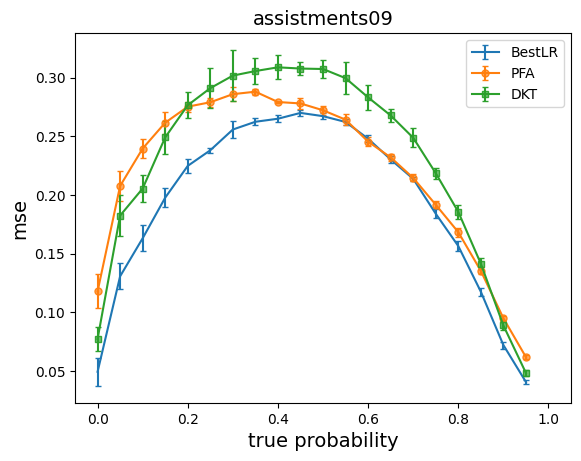

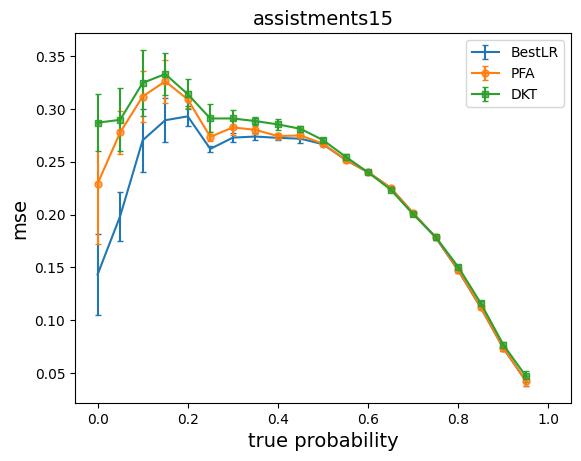

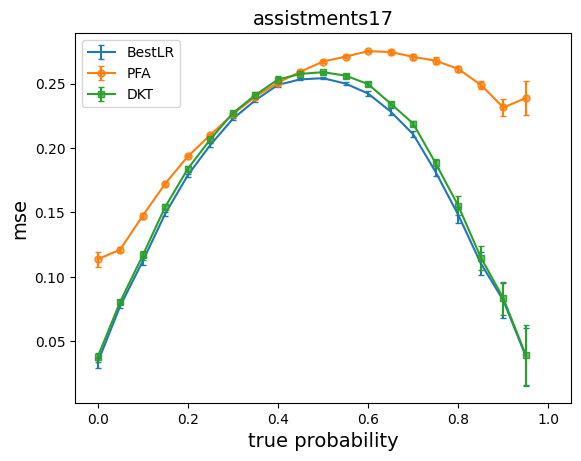

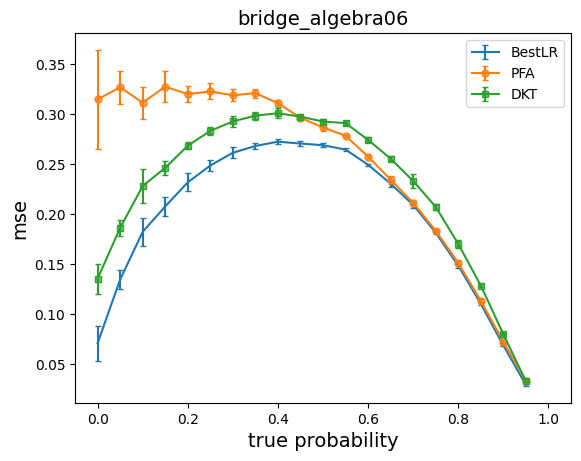

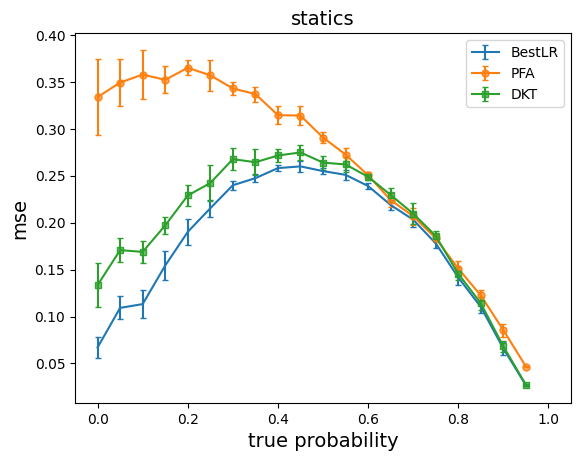

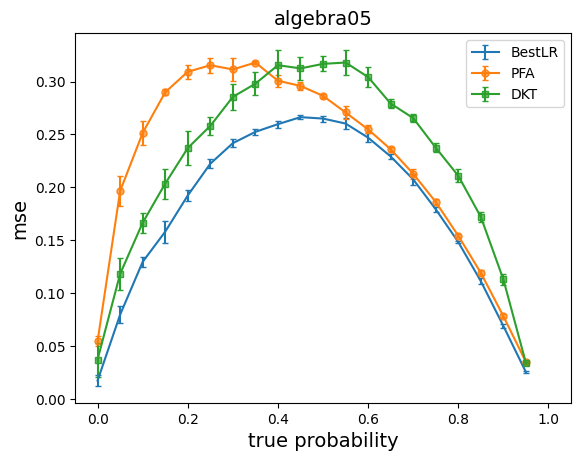

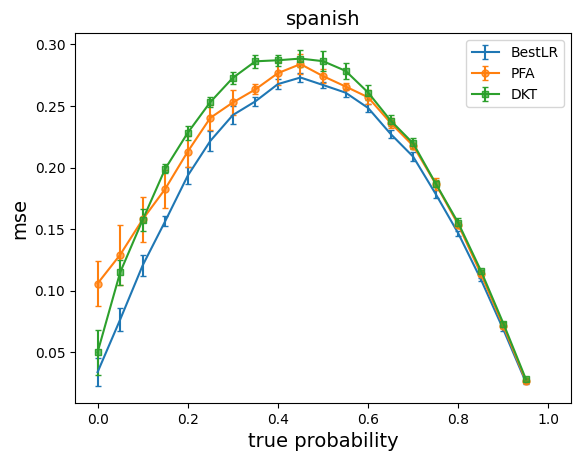

In [100]:
import matplotlib.pyplot as plt

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
markers = ["", "o", "s"]

def plot_metrics_by_prob(dataset, sim_src, models, avg_folds=True, metric="mse"):
    for i, model in enumerate(models):
        kind = "item"
        if(isinstance(model, tuple)):
            model, kind = model
        if(avg_folds):
            stats = get_kfold_stats(dataset, sim_src, model, kind)
            bins, stats_by_prob = zip(*stats["metrics_by_prob"])
            metric_vals = [x[metric]['avg'] for x in stats_by_prob]
            metric_stds = [x[metric]['std'] for x in stats_by_prob]
            plt.errorbar([x[0] for x in bins], metric_vals, yerr=metric_stds, label=model, marker=markers[i],
                         fmt='-', markersize=5, capsize=2, mfc=colors[i]+"aa", mec=colors[i]+"ee")
        else:
            stats = get_stats(dataset, sim_src, model, kind)
            bins, stats_by_prob = zip(*stats["metrics_by_prob"])
            metric_vals = [x[metric] for x in stats_by_prob]
            plt.scatter([x[0] for x in bins], metric_vals, label=model)
    plt.ylabel(metric, fontsize=14)
    plt.xlabel("true probability",fontsize=14)
    plt.title(dataset,fontsize=14)
    plt.xlim(-.05, 1.05)
    plt.legend()
    plt.show()



plot_metrics_by_prob('assistments09', "BestLR",  ["BestLR", "PFA", "DKT"])
plot_metrics_by_prob('assistments15', "BestLR", ["BestLR", "PFA", "DKT"])
plot_metrics_by_prob('assistments17', "BestLR", ["BestLR", "PFA", "DKT"])
plot_metrics_by_prob('bridge_algebra06', "BestLR",  ["BestLR", "PFA", "DKT"])
plot_metrics_by_prob('statics', "BestLR",  ["BestLR", "PFA", "DKT"])
plot_metrics_by_prob('algebra05', "BestLR",  ["BestLR", "PFA", "DKT"])
plot_metrics_by_prob('spanish', "BestLR",  ["BestLR", "PFA", "DKT"])




In [137]:
auc_train, auc_test = load_fit_eval_deep("assistments09")
print(f"DKT on REAL (AUC) Train: {auc_train} Test: {auc_test}")

Step 20, {'loss/train': 0.5930243015289307, 'auc/train': 0.6723344037953826}
Step 20, {'auc/val': 0.74285085518458}
Step 40, {'loss/train': 0.5423457533121109, 'auc/train': 0.7517106827942353}
Step 40, {'auc/val': 0.7622018025258173}
Step 60, {'loss/train': 0.5064413413405419, 'auc/train': 0.7953357869098212}
Step 60, {'auc/val': 0.7701891388040335}
Step 80, {'loss/train': 0.46225973069667814, 'auc/train': 0.8337672252119626}
Step 80, {'auc/val': 0.7719971352286149}
Step 100, {'loss/train': 0.42171138525009155, 'auc/train': 0.8665061370366838}
Step 100, {'auc/val': 0.7655686859590765}
Step 120, {'loss/train': 0.38699825555086137, 'auc/train': 0.8886522511324202}
Step 120, {'auc/val': 0.7557986549733957}
Step 140, {'loss/train': 0.3505245134234428, 'auc/train': 0.91012155493646}
Step 140, {'auc/val': 0.7469818845017311}
Step 160, {'loss/train': 0.31534802466630935, 'auc/train': 0.9283812214010062}
Step 160, {'auc/val': 0.7354199269089058}
Step 180, {'loss/train': 0.2870065078139305, 'au

In [6]:
stats = load_fit_eval_deep("assistments09", is_sim=True)
print(stats)

Step 20, {'loss/train': 0.5930243015289307, 'auc/train': 0.6723344037953826}
Step 20, {'auc/val': 0.74285085518458}
Step 40, {'loss/train': 0.5423457533121109, 'auc/train': 0.7517106827942353}
Step 40, {'auc/val': 0.7622018025258173}
Step 60, {'loss/train': 0.5064413413405419, 'auc/train': 0.7953357869098212}
Step 60, {'auc/val': 0.7701891388040335}
Step 80, {'loss/train': 0.46225973069667814, 'auc/train': 0.8337672252119626}
Step 80, {'auc/val': 0.7719971352286149}
Step 100, {'loss/train': 0.42171138525009155, 'auc/train': 0.8665061370366838}
Step 100, {'auc/val': 0.7655686859590765}
Step 120, {'loss/train': 0.38699825555086137, 'auc/train': 0.8886522511324202}
Step 120, {'auc/val': 0.7557986549733957}
Step 140, {'loss/train': 0.3505245134234428, 'auc/train': 0.91012155493646}
Step 140, {'auc/val': 0.7469818845017311}
Step 160, {'loss/train': 0.31534802466630935, 'auc/train': 0.9283812214010062}
Step 160, {'auc/val': 0.7354199269089058}
Step 180, {'loss/train': 0.2870065078139305, 'au

In [97]:
auc_train, auc_test = load_fit_eval_lr("assistments09", "BestLR")
print(f"BESTLR on REAL (AUC) Train: {auc_train} Test: {auc_test}")

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


BESTLR on REAL (AUC) Train: 0.8229472125317272 Test: 0.7666073708657459


In [ ]:
auc_train, auc_test = load_fit_eval_lr("assistments09", "BestLR", is_sim=True)
print(f"BESTLR on SIM (AUC) Train: {auc_train} Test: {auc_test}")

In [99]:
auc_train, auc_test = load_fit_eval_lr("assistments09", "PFA")
print(f"PFA on REAL (AUC) Train: {auc_train} Test: {auc_test}")

PFA on REAL (AUC) Train: 0.7212668034833476 Test: 0.7085018645511809


In [100]:
auc_train, auc_test = load_fit_eval_lr("assistments09", "PFA", is_sim=True)
print(f"PFA on SIM (AUC) Train: {auc_train} Test: {auc_test}")

PFA on SIM (AUC) Train: 0.6926758204839265 Test: 0.6834338525139869


        user_id  item_id  timestamp  correct  skill_id
0             0    12661          0        0       143
1             0    12685          0        1       143
2             0    12678          0        0       143
3             0    12697          0        0       143
4             0    12698          0        0       143
...         ...      ...        ...      ...       ...
278331     3113      630          0        1        82
278332     3113      624          0        1        82
278333     3113      616          0        1        82
278334     3113      980          0        1        24
278335     3113     5992          0        1       100

[278336 rows x 5 columns]


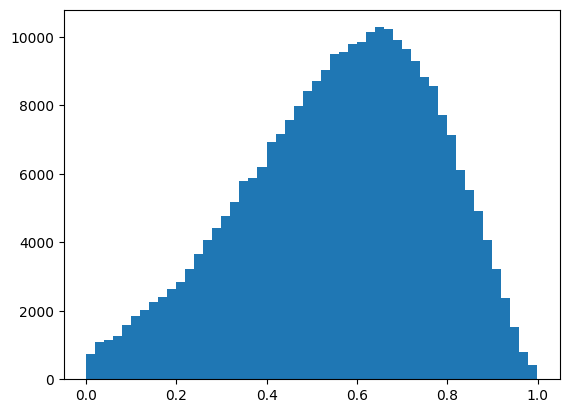

In [69]:
dataset = "assistments09"
X_file = "X-sscwa.npz"
    
X = csr_matrix(load_npz(f'data/{dataset}/{X_file}'))
#df = pd.read_csv(f'data/{dataset}/preprocessed_data.csv', sep="\t")
sim_df = pd.read_csv(f'simulation/simulated-data/{dataset}/{dataset}.csv', sep="\t")
print(df)

import matplotlib.pyplot as plt
import numpy as np


#plt.hist(df['prob'], bins=50)
plt.hist(sim_df['prob'], bins=50)
plt.show()
